<h1>Identifying Wine Heritage By Chemical Composition</h1>

1. Title of Database: Wine recognition data
        Updated Sept 21, 1998 by C.Blake : Added attribute information

2. Sources:
   (a) Forina, M. et al, PARVUS - An Extendible Package for Data
       Exploration, Classification and Correlation. Institute of Pharmaceutical
       and Food Analysis and Technologies, Via Brigata Salerno,
       16147 Genoa, Italy.

   (b) Stefan Aeberhard, email: stefan@coral.cs.jcu.edu.au
   (c) July 1991


Note that we use global variables throughout this.  A better way to do this for production code would be to make a class, but this is just a small demo.

In [3]:
from numpy import *
from matplotlib.pyplot import *
from scipy.optimize import fmin_bfgs,minimize
import csv
import time as t


# Globals to control parameters
regParam = 0.003
nSPerClass = 40
nS = 3*nSPerClass

class1start = 0
class2start = 59
class3start = 130

data = csv.reader(open('uciWineLocation.csv','r'))
rowInd = 0
inData = []
outData = []
outSData = []
testBin = 3*[0]

# Read the data as strings
# Just continue with global variables - it is a small program
for row in data:
    for ri in range(len(row)):
        row[ri] = float(row[ri])
    inData.append(row[1:])
    for ri in range(1,4):
        testBin[ri-1] = (row[0]==float(ri))
    outData.append(testBin.copy())
    outSData.append(row[0])
    
# Parcel into training data, leaving some out
trainX = array(inData[:nSPerClass]+inData[class2start:class2start+nSPerClass]+inData[class3start:class3start+nSPerClass])
trainY = array(outData[:nSPerClass]+outData[class2start:class2start+nSPerClass]+outData[class3start:class3start+nSPerClass]).astype(float)
trainSY = array(outSData[:nSPerClass]+outSData[class2start:class2start+nSPerClass]+outSData[class3start:class3start+nSPerClass]).astype(float)
nInput = len(trainX[0])
nOutput = 3
nHidden = int(2*nInput/3+nOutput)

print('Number of samples: {}'.format(len(inData)))
print('Number of data vectors: {}'.format(nS))
print('Number of data items: {}'.format(nInput))
print('Number of hidden cells: {}'.format(nHidden))

nW0 = nInput*nHidden
nW1 = nHidden*nOutput
nVar = nW0+nW1+nHidden+nOutput

Number of samples: 178
Number of data vectors: 120
Number of data items: 13
Number of hidden cells: 11


Here is some normalization stuff.

In [4]:
def normalization(col):
    # Normalize a column of input data
    numSamp = float(len(col))
    mu = sum(col)/numSamp
    l2norm = sqrt(sum((col-mu)*(col-mu))/numSamp)
    return mu,l2norm

# Find normalization coefficients for each column
def normalizationConst():
    muVals = []
    normVals = []
    for i in range(nInput):
        mu,nrm = normalization(trainX[:,i])
        muVals.append(mu)
        normVals.append(nrm)
    muVals = array(muVals)
    normVals = array(normVals)
    return muVals,normVals

# Normalize the rows
muVals, normVals = normalizationConst()
def normalizeByTrain(inputMatrix):
    nSamp = len(inputMatrix[:,0])
    for k in range(nSamp):
        inputMatrix[k] = (inputMatrix[k]-muVals)/normVals
    return inputMatrix

trainX = normalizeByTrain(trainX)

Initialize weights, feed forward and cost/loss functions.

In [5]:
globalW = random.rand(nVar)

output = eye(nOutput)

def feedForward(x,W):
    W0 = array(W[:nW0]).reshape(nHidden,nInput)
    W1 = array(W[(nW0+nHidden):-nOutput]).reshape(nOutput,nHidden)
    hiddenResult = a1(W0.dot(x)+W[nW0:(nW0+nHidden)])
    z2 = W1.dot(hiddenResult)+W[-nOutput:]
    return a2(z2)

def cost(forward,output,W):
    return 0.5*( dot(forward-output,forward-output)+regParam*linalg.norm(W)**2 )

# The following only works if a2=softmax, so we hard coded it
def crossEntropyCost(forward,output,W):
    return -sum(output*log(forward))+regParam*0.5*linalg.norm(W)**2

Here are the activations and a gradient for a one-hidden-layer network.  Note that we can pick activations by setting the a1,a1p, a2, and a2p variables.

Note also that we just used a sum of costs and grads for our ensemble cost and grad.

In [6]:
def S(X):
    X = X*(abs(X)<10)+10.*(X>=10)-10.*(X<=-10)
    return 1./(1+exp(-X))

def SPrime(X):
    X = X*(abs(X)<10)+10.*(X>=10)-10.*(X<=-10)
    ex = exp(-X)
    return ex/((1.+ex)*(1.+ex))

def relu(x,epsilon=0.0):
    return x*(x>0)+epsilon*x*(x<=0)

def reluPrime(x,epsilon=0.0):
    return (x>0)+epsilon*(x<=0)

def selu(x,lamda=1,alpha=1):
    return lamda*( x*(x>0)+alpha*(exp(x)-1)*(x<=0))

def seluPrime(x,lamda=1,alpha=1):
    return lamda*((x>0)+alpha*exp(x)*(x<=0))

def softmax(x):
    aX = exp(x)
    return aX/sum(aX)

a1 = lambda x: relu(x,epsilon=.1)
a1p = lambda x: reluPrime(x,epsilon=.1)
a2 = S
a2p = SPrime

def gradient(x,out,W):
    W0 = array(W[:nW0]).reshape(nHidden,nInput)
    W1 = array(W[nW0+nHidden:-nOutput]).reshape(nOutput,nHidden)
    grad = W*0.0
    # Get a(z_2)
    z1 = dot(W0,x)+W[nW0:nW0+nHidden]
    z2 = dot(W1,a1(z1))+W[-nOutput:]
    forward = a2(z2)
    err = forward-out
    # gradient for b_1 bias weights
    finalLayerDeriv = a2p(z2)*err
    grad[-nOutput:] = finalLayerDeriv+0.
    # gradient for W_1 weights
    grad[(nW0+nHidden):-nOutput] = outer(finalLayerDeriv,a1(z1)).flatten()
    # gradient for b_0 bias weights
    firstLayerDeriv = finalLayerDeriv.dot(W1)*a1p(z1)
    grad[nW0:(nW0+nHidden)] = firstLayerDeriv+0.
    # gradient for W_0 weights
    grad[:nW0] = outer(firstLayerDeriv,x).flatten()
    return grad+regParam*W

# Again, this only works when a2=softmax, so we just hard code it.
def crossEntropyGradient(x,out,W):
    W0 = array(W[:nW0]).reshape(nHidden,nInput)
    W1 = array(W[nW0+nHidden:-nOutput]).reshape(nOutput,nHidden)
    grad = W*0.0
    # Get a(z_2)
    z1 = dot(W0,x)+W[nW0:nW0+nHidden]
    z2 = dot(W1,a1(z1))+W[-nOutput:]
    forward = softmax(z2)
    # gradient for b_1 bias weights
    finalLayerDeriv = forward-out
    grad[-nOutput:] = finalLayerDeriv+0.
    # gradient for W_1 weights
    grad[(nW0+nHidden):-nOutput] = outer(finalLayerDeriv,a1(z1)).flatten()
    # gradient for b_0 bias weights
    firstLayerDeriv = finalLayerDeriv.dot(W1)*a1p(z1)
    grad[nW0:(nW0+nHidden)] = firstLayerDeriv+0.
    # gradient for W_0 weights
    grad[:nW0] = outer(firstLayerDeriv,x).flatten()
    return grad+regParam*W

def gradSum(W,X,Y):
    nSamp = len(X[:,0])
    grad = zeros(nVar)
    for i in range(nSamp):
        grad += gradient(X[i,:],Y[i,:],W)
    return grad

def crossEntropyGradSum(W,X,Y):
    nSamp = len(X[:,0])
    grad = zeros(nVar)
    for i in range(nSamp):
        grad += crossEntropyGradient(X[i,:],Y[i,:],W)
    return grad

def forwardTest(W,x,y):
    return cost(feedForward(x,W),y,W)

def crossEntropyTest(W,x,y):
    a2 = softmax
    return crossEntropyCost(feedForward(x,W),y,W)

def forwardTestAll(W,X,Y):
    tot = 0.
    nSamp = len(X[:,0])
    for i in range(nSamp):
        xSamp = X[i,:]
        ySamp = Y[i,:]
        tot += forwardTest(W,xSamp,ySamp)
    return tot    

def crossEntropyTestAll(W,X,Y):
    tot = 0.
    nSamp = len(X[:,0])
    for i in range(nSamp):
        xSamp = X[i,:]
        ySamp = Y[i,:]
        tot += crossEntropyTest(W,xSamp,ySamp)
    return tot    

In [7]:
newW = globalW+0.
nStep = 8
fDiff = 1.
fOut = 0.
k = 0
t0 = t.time()
while fDiff>1e-6 and k<nStep:
    k += 1
    #newW = fmin_bfgs(forwardTestAll,newW,args=(trainX,trainY),gtol=1e-10)
    results = fmin_bfgs(crossEntropyTestAll,newW,fprime=crossEntropyGradSum,args=(trainX,trainY),full_output=True)
    #resObj = minimize(forwardTestAll,newW,args=(trainX,trainY),jac='2-point',method='BFGS')
    #resObj = minimize(forwardTestAll,newW,args=(trainX,trainY),jac=gradSum,method='BFGS')
    #resObj = minimize(forwardTestAll,newW,args=(trainX,trainY),jac='2-point',method='Newton-CG')
    #resObj = minimize(forwardTestAll,newW,args=(trainX,trainY),jac=gradSum,method='Newton-CG')
    #newW = resObj.x
    newW = results[0]
    oldFOut = fOut
    fOut = results[1]
    fDiff = abs(fOut-oldFOut)
elapsedTime = t.time()-t0
print('Elapsed time: {}'.format(elapsedTime))

         Current function value: 7.586447
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 54
         Current function value: 5.070339
         Iterations: 14
         Function evaluations: 83
         Gradient evaluations: 71
         Current function value: 5.070339
         Iterations: 0
         Function evaluations: 71
         Gradient evaluations: 59
Elapsed time: 4.305830240249634


In [8]:
# Import datasets, classifiers and performance metrics
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

<h1>Scikit-Learn Version</h1>
Just as a comparison, we solve the same problem using scikit-learn.  Observe that it is dramatically faster.  This is because it is compiled code from front to back, while our Python code calls our <em>interpreted</em> cost and gradient functions repeatedly.  If we were dead set on using our own code for the NN, we would really need to do some JIT compilation on our cost and gradient functions.

In [9]:
# Create a classifier: a support vector classifier
clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(nHidden), random_state=1)

t0 = time.time()
clf.fit(trainX, trainSY)
elapsedTime = t.time()-t0
print('Elapsed time: {}'.format(elapsedTime))

# Predict the location
#predicted = clf.predict(testX)
#predErr = predicted-(testSY)
#print(predicted)
#print(sum(abs(predErr))/nTest)

Elapsed time: 0.027851104736328125


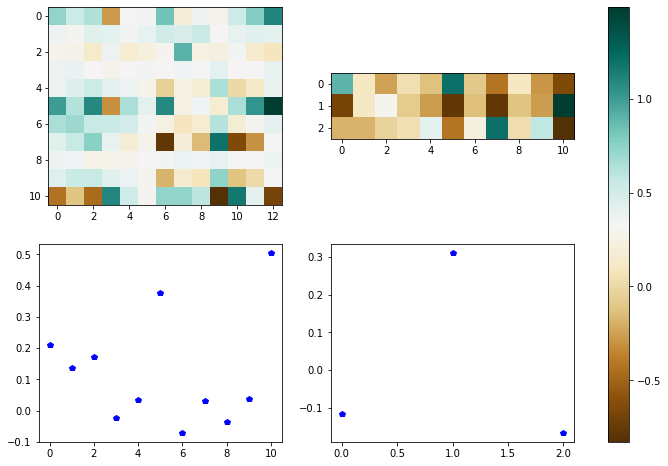

In [10]:
from matplotlib.pyplot import *
W0 = array(newW[:nW0]).reshape(nHidden,nInput)
W1 = array(newW[nW0+nHidden:-nOutput]).reshape(nOutput,nHidden)
b0 = array(newW[nW0:nW0+nHidden])
b1 = array(newW[-nOutput:])
f, ax = subplots(2,2)
im = ax[0,0].imshow(W0, cmap=get_cmap('BrBG'), vmin=W0.min(), vmax=W0.max())
im = ax[0,1].imshow(W1, cmap=get_cmap('BrBG'), vmin=W1.min(), vmax=W1.max())
ax[1,0].plot(b0,'bp')
ax[1,1].plot(b1,'bp')
#im.set_interpolation('bilinear')
cb = f.colorbar(im, ax=ax)
f.set_figwidth(12)
f.set_figheight(8)
show()